# Рубежный контроль №2 по предмету "Технологии машинного обучения"

**Имя студента:** Пересыпко Александр, РТ5-61Б  
**Датасет:** marvel-wikia-data.csv   https://www.kaggle.com/fivethirtyeight/fivethirtyeight-comic-characters-dataset 
**Вариант 13**  
**Метод 1:**  Дерево решений 
**Метод 2:**  Градиентный бустинг

---

## Описание датасета

Датасет содержит несколько параметров, которые считаются важными при подаче заявления на программы магистратуры, и вероятность поступить в магистратуру


### Основные атрибуты:
- **page_id**  
  Уникальный числовой идентификатор страницы персонажа в Wikia.  
- **name**  
  Имя персонажа.  
- **urlslug**  
  Уникальная часть URL, ведущая на страницу персонажа.  
- **ID**  
  Тип личности: Secret Identity (секретная), Public Identity (публичная), No Dual Identity (только для Marvel).  
- **ALIGN**  
  Выравнивание (Good, Bad, Neutral).  
- **EYE**  
  Цвет глаз персонажа.  
- **HAIR**  
  Цвет волос персонажа.  
- **SEX**  
  Пол персонажа (Male, Female и т. п.).  
- **GSM**  
  Признак гендерного или сексуального меньшинства (например, гомосексуальные, бисексуальные и т. д.).  
- **ALIVE**  
  Статус: alive (жив) или deceased (умер).  
- **APPEARANCES**  
  Число появлений персонажа в комиксах (на 2 сентября 2014).  
- **FIRST APPEARANCE**  
  Месяц и год первого появления персонажа в комиксах (если доступно).  
- **YEAR**  
  Год первого появления (если доступно).  

---

## Задание

Для заданного набора данных (по Вашему варианту) постройте модели классификации или регрессии (в зависимости от конкретной задачи, рассматриваемой в наборе данных). Для построения моделей используйте методы 1 и 2 (по варианту для Вашей группы). Оцените качество моделей на основе подходящих метрик качества (не менее двух метрик). Какие метрики качества Вы использовали и почему? Какие выводы Вы можете сделать о качестве построенных моделей? Для построения моделей необходимо выполнить требуемую предобработку данных: заполнение пропусков, кодирование категориальных признаков, и т.д.


In [37]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Загрузка данных из CSV файла
df = pd.read_csv('marvel-wikia-data.csv')

# Отображение первых нескольких строк исходного DataFrame
print("Исходный DataFrame:")
print(df.head(5))

Исходный DataFrame:
   page_id                                 name  \
0     1678            Spider-Man (Peter Parker)   
1     7139      Captain America (Steven Rogers)   
2    64786  Wolverine (James \"Logan\" Howlett)   
3     1868    Iron Man (Anthony \"Tony\" Stark)   
4     2460                  Thor (Thor Odinson)   

                                   urlslug                ID  \
0              \/Spider-Man_(Peter_Parker)   Secret Identity   
1        \/Captain_America_(Steven_Rogers)   Public Identity   
2  \/Wolverine_(James_%22Logan%22_Howlett)   Public Identity   
3    \/Iron_Man_(Anthony_%22Tony%22_Stark)   Public Identity   
4                    \/Thor_(Thor_Odinson)  No Dual Identity   

                ALIGN         EYE        HAIR              SEX  GSM  \
0     Good Characters  Hazel Eyes  Brown Hair  Male Characters  NaN   
1     Good Characters   Blue Eyes  White Hair  Male Characters  NaN   
2  Neutral Characters   Blue Eyes  Black Hair  Male Characters  NaN   
3   

### Удаляем ненужные фичи

In [38]:
df = df.drop(['page_id', 'name', 'urlslug', 'FIRST APPEARANCE', 'GSM'], axis=1)


### Подсчитаем количество строк с пропусками в датасете

In [39]:
initial_row_count = df.shape[0]

total_count = df.shape[0]
print('Всего строк: {}'.format(total_count))

df.isnull().sum()

Всего строк: 16376


ID             3770
ALIGN          2812
EYE            9767
HAIR           4264
SEX             854
ALIVE             3
APPEARANCES    1096
Year            815
dtype: int64

In [ ]:
cat_cols = ['ID', 'ALIGN', 'EYE', 'HAIR', 'SEX', 'GSM', 'ALIVE', 'APPEARANCES']
for col in cat_cols:
    df[col] = df[col].replace('', np.nan).fillna(df[col].median())

initial_row_count = df.shape[0]

total_count = df.shape[0]
print('Всего строк: {}'.format(total_count))
df.isnull().sum()

### Закодируем категориальные признаки

In [40]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

# Категориальные колонки
cat_cols = ['ID', 'ALIGN', 'EYE', 'HAIR', 'SEX', 'ALIVE']

# 1) Label-encode для ALIGN
le = LabelEncoder()
df['ALIGN'] = le.fit_transform(df['ALIGN'].astype(str))

# 2) OneHotEncoder с новым параметром sparse_output=False
ohe_cols = [c for c in cat_cols if c != 'ALIGN']
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
ohe_array = ohe.fit_transform(df[ohe_cols].astype(str))
ohe_names = ohe.get_feature_names_out(ohe_cols)

# Собираем DataFrame из ohe-результатов
ohe_df = pd.DataFrame(ohe_array, columns=ohe_names, index=df.index)

# 3) Итоговый df: удаляем оригинальные ohe_cols и добавляем новые one-hot
df = pd.concat([df.drop(columns=ohe_cols), ohe_df], axis=1)

from sklearn.preprocessing import StandardScaler

# Перечень числовых признаков для масштабирования
numeric_cols = ['APPEARANCES', 'Year']

# Инициализируем и применяем StandardScaler
scaler = StandardScaler()
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

# Проверим результат
df[numeric_cols].head()

df.head()

,ALIGN,APPEARANCES,Year,ID_Known to Authorities Identity,ID_No Dual Identity,ID_Public Identity,ID_Secret Identity,ID_nan,EYE_Amber Eyes,EYE_Black Eyeballs,...,HAIR_Yellow Hair,HAIR_nan,SEX_Agender Characters,SEX_Female Characters,SEX_Genderfluid Characters,SEX_Male Characters,SEX_nan,ALIVE_Deceased Characters,ALIVE_Living Characters,ALIVE_nan
0,1,41.776224,-1.167262,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,1,34.688942,-2.235261,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,2,31.586311,-0.556977,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,1,30.548641,-1.116405,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,1,23.253825,-1.777547,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


### Заполняем пропуски
Для всех столбцов, кроме year - медианой, year не трогаем

Всего строк: 16376


ID               0
ALIGN            0
EYE              0
HAIR             0
SEX              0
GSM              0
ALIVE            0
APPEARANCES      0
Year           815
dtype: int64

### Разобьем датасет: в тест поместим ноды с пропусками в year и добавим до 10%

In [17]:
from sklearn.model_selection import train_test_split

mask_missing_year = df['Year'].isna()

# Группа с пропусками и без
df_missing = df[mask_missing_year]
df_not_missing = df[~mask_missing_year]

# Вычисляем, сколько всего строк в тесте (10% от всего датасета)
total_n = len(df)
test_total_n = int(total_n * 0.1)

# Сколько взять из df_not_missing, чтобы вместе с df_missing получилось 10%
rest_test_n = test_total_n - len(df_missing)
test_size_rest = rest_test_n / len(df_not_missing)

# Делаем train-test сплит по непустым
df_train_rest, df_test_rest = train_test_split(
    df_not_missing,
    test_size=test_size_rest,
    random_state=42,
    shuffle=True
)

# Собираем финальные выборки
train_df = df_train_rest.reset_index(drop=True)
test_df = (
    pd.concat([df_test_rest, df_missing], axis=0)
      .sample(frac=1, random_state=42)
      .reset_index(drop=True)
)

print(f"Train shape: {train_df.shape}")
print(f"Test shape:  {test_df.shape}")

Train shape: (14739, 9)
Test shape:  (1637, 9)


### Добавим категориальный признак

Для этого разобьем GRE score на 3 категории: низкий средний и высокий

In [12]:
bins = [ -np.inf, 50, 75, np.inf ]
labels = ['низкий', 'средний', 'высокий']
df['score_cat'] = pd.cut(df['GRE Score'], bins=bins, labels=labels, right=False)


### Строк с пропусками нет. Добавим их случайно

Добавим пропуски в категориальный признак GRE Score и в числовой CGPA

In [13]:
# задаём долю пропусков для каждого признака
frac_gre = 0.1    # 10% GRE Score
frac_cgpa = 0.05  # 5% CGPA

# выбираем случайные индексы для каждого
gre_idx = df.sample(frac=frac_gre, random_state=42).index
cgpa_idx = df.sample(frac=frac_cgpa, random_state=24).index

# вставляем NaN
df.loc[gre_idx, 'GRE Score'] = np.nan
df.loc[cgpa_idx, 'CGPA'] = np.nan

print('Пропущенные в GRE Score и CGPA:')
print(df[['GRE Score', 'CGPA']].isnull().sum())

Пропущенные в GRE Score и CGPA:
GRE Score    40
CGPA         20
dtype: int64


## Обработка пропусков

In [14]:
from sklearn.impute import SimpleImputer
imp = SimpleImputer(strategy='most_frequent')

df['GRE Score'] = imp.fit_transform(df[['GRE Score']])

print('Пропущенных в GRE Score после заполнения:', df['GRE Score'].isnull().sum())

Пропущенных в GRE Score после заполнения: 0


In [15]:
imp_cgpa = SimpleImputer(strategy='mean')
df['CGPA'] = imp_cgpa.fit_transform(df[['CGPA']])
print('Пропущенных в CGPA после заполнения:', df['CGPA'].isnull().sum())

Пропущенных в CGPA после заполнения: 0


### Для студентов группы РТ5-61Б - для пары произвольных колонок данных построить график "Jointplot".

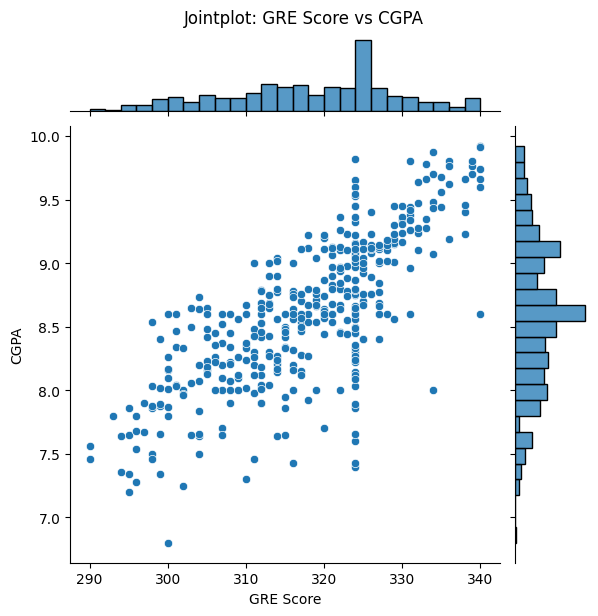

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

col_x = 'GRE Score'
col_y = 'CGPA'

sns.jointplot(
    x=col_x,
    y=col_y,
    data=df,
    kind='scatter',
    height=6,
    marginal_kws=dict(bins=25, fill=True)
)

plt.suptitle(f'Jointplot: {col_x} vs {col_y}', y=1.02)
plt.show()

# Ответы на вопросы

---

### Какие способы обработки пропусков в данных для категориальных и количественных признаков Вы использовали?

• Категориальный признак (GRE Score)
– SimpleImputer(strategy='most_frequent')
– Заполнили пустые значения наиболее часто встречающимся баллом GRE.

• Количественный признак (CGPA)
– SimpleImputer(strategy='mean')
– Заполнили пропуски средним значением CGPA по всей выборке.

---

### Какие признаки Вы будете использовать для дальнейшего построения моделей машинного обучения и почему?

• GRE Score, CGPA
– Ключевые академические метрики, сильная корреляция с целевой переменной (Admission Chance).

• TOEFL Score
– Аналогичный по значимости тест, также числовой, легко нормировать.

• University Rating, SOP, LOR
– Категориальные/ранжировочные факторы, отражают престиж университета и качество рекомендаций/мотивации.
– Будут преобразованы в dummy‑переменные или порядковые коды.

• Research (0/1)
– Бинарный признак, важный индикатор опыта, не требует дополнительной обработки.

Отобранные признаки дают сбалансированный набор академических, рейтинговых и бинарных факторов, что обычно улучшает обобщающую способность моделей регрессии или классификации в задачах предсказания шансов поступления.

